In [28]:
import random
import statistics as st
import math as mt
import numpy as np
import time
import itertools
from multiprocessing import Process, Queue, Lock, Array, Value
MAX_NUM =2**9
global rand_nums 
rand_nums = random.sample(range(1, MAX_NUM*2), MAX_NUM)
global mat_size 
mat_size =  len(rand_nums)
global N
N=len(rand_nums)
def ser_median():
    ser_med=np.median(rand_nums)
    print('Median calculation using Pythons numpy {}'.format(ser_med))

In [29]:
n = 1        # Number of loops
r = 1       # Number of repetitions of each loop
p = 6        # Display precision
t_serial = %timeit -n $n -r $r -p $p -o pass; func = ser_median()
print('Time taken for serial median calculation {} in (ms)'.format(t_serial.average*1000))

Median calculation using Pythons numpy 515.5
789.167 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Time taken for serial median calculation 0.7891669993114192 in (ms)


# Median calculation using parallel approach
## Algorithm


While(len(list)>2*nofProcs)):

    Step1: Split the list among all the child processes

    Step2: Each child process will calculate it's median and store it in a shared memory
           and each process will set a shared flag, childs_wait[proc no] to True, indicating that 
           it's done with it's job and it will wait for parent process to calculate MoM. If MoMcalc
           flag is set by Parent then all children will go ahead and see if MoM>local median or otherwise.
           if(MoM>local median) then local list values to the right of the local median including median
           are put in a shared space and corresponding return_wait flag is set otherwise elements to the
           left of median are put in a shared space.
       
    Step3: Parent process will calculate MoM only if all child processes are 
           done calculating their medians, i.e  sum(childs_wait[proc no])==No.Of Procs
           and set it's own flag, MoMcalc to True. This MoM is put in a shared memory space so that 
           children can access it.
       
    Step4: if(sum(return_wait[proc no]))==NoOfProcs it means that all processes have returned
           reduced lists and parent will combine the lists and redistribute that newer list
           to all child processes.
        

In [30]:
def para_med(procs):
    NUMPROCS=procs
    def medians(sub_list,child_waits,MoMcalc,MoM,child_meds,return_lists,proc,return_wait):
        #Quick Slect algorithm is a special case of quicksort(O(nlogn)), quickselect runs in O(n)
        #because it recurses only on one side, see the Quickselect function. Implemented using
        #Quickselect algorthm from wikipedia, here quickselect will return len(list)/2 th 
        #greatest/smallest element because we're looking for median, at the end the median
        # will be at the center and to it's left all the values will be smaller than the median
        #(not necessatily sorted) and to it's right all the values are larger(not necessatily sorted)
        def Partition(A,start,end):
            pivot = A[end]             ##Start with the last element as pivot
            pIndex = start             ##Partition index or wall, start with the first element.
            for z in range(start,end): ##Whenever there is a present element smaller than pivot element exchange present 
                if(A[z]<=pivot):       #present element with A[pIndex] or wall and increase pIndex by 1. This increase is to
                    c = A[z]           #move the wall to right.
                    A[z]=A[pIndex]
                    A[pIndex]=c
                    pIndex+=1
            k = A[end]
            A[end]=A[pIndex]
            A[pIndex]=k
            return pIndex

        def Quickselect(A,start,end,k):
            if(start==end):
                return A[start]
            pivotIndex=Partition(A,start,end)
            if(k==pivotIndex):
                return A[k]
            elif(k<pivotIndex):
                return Quickselect(A,start,pivotIndex-1,k)
            else:
                return Quickselect(A,pivotIndex+1,end,k)

        cm=Quickselect(sub_list,0,len(sub_list)-1,int(len(sub_list)/2))
        child_meds[proc-1]=cm
        childs_wait[proc-1]=1.0

        while MoMcalc.value!=1.0: ##Children waiting for parent to calculate MoM
            time.sleep(0.0001)

        if(MoM.value>cm):   ##Children return correpsonding sections of sublist and setting return_wait flag
            return_lists.put(sub_list[int(len(sub_list)/2):])
            return_wait[proc-1]=1.0
        else:
            return_lists.put(sub_list[:int(len(sub_list)/2)])
            return_wait[proc-1]=1.0
       
    while N>2*NUMPROCS:
        childs_wait = Array('d',[0.0]*NUMPROCS)
                                        #[T/F,T/F,...], If True child has finished calcing cm(child median)
                                        #If all are True then Parent can go ahead and calc MoM
        
        MoMcalc = Value('d',0.0)        #If True MoM calc by parent is done and child can proceed
        MoM= Value('d',0.0)
        child_meds=Array('d',range(NUMPROCS))
        return_lists = Queue()

        return_wait = Array('d',[0.0]*NUMPROCS)
                                #[T/F,T/F,...], If True child has finished returning new sublist
                                #If all are True then Parent can go ahead make new list 
        mybounds =[0]*NUMPROCS
        q = int(mat_size/NUMPROCS)
        rem = int(mat_size%NUMPROCS)          #This block makes sure that elements are
        for j in range(q):                    #divided evenly across processes, no
            for k in range(NUMPROCS):         #process will get not more than 1 element
                mybounds[k]+=1                #compared to other processes. 
        for l in range(rem):                  
            mybounds[l]+=1
        bounds = []
        for m in range(len(mybounds)):
            bounds.append(sum(mybounds[:m+1]))
        bounds=[0]+bounds
        for n in range(1,NUMPROCS+1):
            lv = bounds[n-1]
            hv = bounds[n]
            job = Process(target = medians, args=[rand_nums[lv:hv],childs_wait,MoMcalc,MoM,child_meds,return_lists,n,return_wait])
            job.start()

        while sum(childs_wait[:])!=NUMPROCS: ## Parent Waiting for all child processes to calc local median
            time.sleep(0.0001)

        MoM.value= np.median(child_meds) ##MoM calc by Parent
        MoMcalc.value = 1.0
        while sum(return_wait[:])!=NUMPROCS:## Parent Waiting for all child processes to return new sublists
            time.sleep(0.0001)

        sml_lists = []
        for i in range(NUMPROCS):
            sml_lists.append(return_lists.get())
        global rand_nums
        rand_nums=list(itertools.chain.from_iterable(sml_lists)) ##Creating a new list using returned sub lists
        global N
        N=len(rand_nums)
        global mat_size
        mat_size = N
    #print(rand_nums)
    print('median using parallel {}'.format(np.median(rand_nums)))

<ipython-input-30-447c4d401414>:91: SyntaxWarning: name 'rand_nums' is used prior to global declaration
  global rand_nums
<ipython-input-30-447c4d401414>:93: SyntaxWarning: name 'N' is used prior to global declaration
  global N
<ipython-input-30-447c4d401414>:95: SyntaxWarning: name 'mat_size' is used prior to global declaration
  global mat_size


In [31]:
## ACTUAL RESULTS
n = 1        # Number of loops
r = 1       # Number of repetitions of each loop
p = 6        # Display precision
times = []
PROCS=[2*i for i in range(1,4)]
for items in PROCS:
    t2 = %timeit -n $n -r $r -p $p -o pass; func = para_med(items)
    times.append(t2.average*1000)

#print(times)
#print('times taken for each of the {} processes is {} in (ms)'.format(NUMPROCS,times))
Sp = [times[0]/times[i] for i in range(len(times))]
Ep = [Sp[i]/PROCS[i] for i in range(0,len(Sp))]
import pandas as p
data = {}
for i in range(len(PROCS)):
    data['Processes='+str(PROCS[i])] = [times[i],Sp[i],Ep[i],PROCS[i]]
df1 = p.DataFrame(data)
df1 = df1.rename(index={2: 'Ep',1:'Sp',0:'times',3:'Processes'})
print('Table showing timings, Efficiency, Speedup, times in (ms)')
print(df1.transpose())
df1=df1.transpose()

median using parallel 515.5
118.374 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
median using parallel 501.5
158.31 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
median using parallel 503.5
229.105 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Table showing timings, Efficiency, Speedup, times in (ms)
                  times        Sp        Ep  Processes
Processes=2  118.373710  1.000000  0.500000        2.0
Processes=4  158.310459  0.747731  0.186933        4.0
Processes=6  229.105457  0.516678  0.086113        6.0


Text(0,0.5,'log(time)')

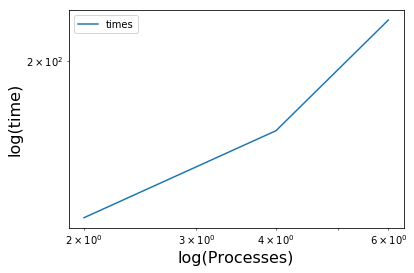

In [32]:
plt1 = df1.plot(x='Processes',y='times',logx=True, logy=True)
plt1.set_xlabel('log(Processes)',fontsize=16)
plt1.set_ylabel('log(time)',fontsize=16)

Text(0,0.5,'Ep')

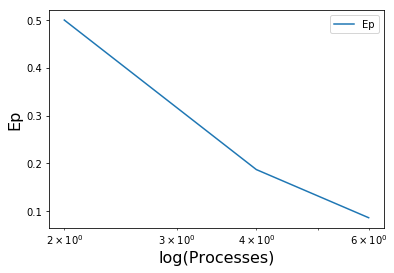

In [33]:
plt2 = df1.plot(x='Processes',y='Ep',logx=True, logy=False)
plt2.set_xlabel('log(Processes)',fontsize=16)
plt2.set_ylabel('Ep',fontsize=16)

In [34]:
## THEORETICAL RESULTS
#print(times)
time1= t_serial.average*1000
times=[]
for items in PROCS:
    times.append(time1/items)
#print(times)
Sp = [time1/items for items in times]
Ep = [Sp[i]/PROCS[i] for i in range(0,len(Sp))]
import pandas as p
data = {}
for i in range(len(PROCS)):
    data['Processes='+str(PROCS[i])] = [times[i],Sp[i],Ep[i],PROCS[i]]
df1 = p.DataFrame(data)
df1 = df1.rename(index={2: 'Ep',1:'Sp',0:'times',3:'Processes'})
print('Table showing timings, Efficiency, Speedup, times in (ms)')
print(df1.transpose())
df1=df1.transpose()

Table showing timings, Efficiency, Speedup, times in (ms)
                times   Sp   Ep  Processes
Processes=2  0.394583  2.0  1.0        2.0
Processes=4  0.197292  4.0  1.0        4.0
Processes=6  0.131528  6.0  1.0        6.0


Text(0,0.5,'log(time)')

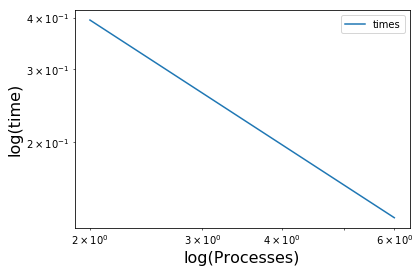

In [35]:
plt1 = df1.plot(x='Processes',y='times',logx=True, logy=True)
plt1.set_xlabel('log(Processes)',fontsize=16)
plt1.set_ylabel('log(time)',fontsize=16)

Text(0,0.5,'Ep')

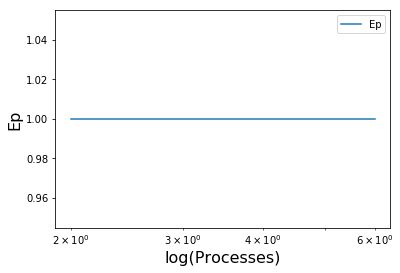

In [36]:
plt2 = df1.plot(x='Processes',y='Ep',logx=True, logy=False)
plt2.set_xlabel('log(Processes)',fontsize=16)
plt2.set_ylabel('Ep',fontsize=16)